In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from collections import Counter

# Exploratory analysis

- import train csv
- exploratory analysis
    - check imbalanced classes
    - change categorical to numeric classes (marital status)
    - check correlations


In [2]:
train_set = pd.read_csv("../database/students-dropout/train.csv")
test_set = pd.read_csv('../database/students-dropout/test.csv')
validation_set = pd.read_csv('../database/students-dropout/validation.csv')

In [4]:
train_set.shape

(2476, 36)

In [4]:
train_set.columns

Index(['Id', 'Marital status', 'Application mode', 'Application order',
       'Course', 'Daytime/evening attendance', 'Previous qualification',
       'Nacionality', 'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evalua

In [5]:
train_set.head()

,Id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Category
0,3222,1,1,1,14,1,1,1,13,28,...,0,6,7,6,14.714286,0,11.1,0.6,2.02,Graduate
1,2388,1,8,4,9,1,1,1,23,14,...,0,5,10,2,12.500000,0,11.1,0.6,2.02,Dropout
2,1865,1,12,1,17,0,1,1,1,1,...,0,5,5,5,12.400000,0,15.5,2.8,-4.06,Graduate
3,652,1,12,1,12,1,12,1,1,5,...,0,8,11,7,12.614286,0,12.7,3.7,-1.70,Graduate
4,4220,1,1,1,14,1,1,1,19,28,...,0,5,5,0,0.000000,0,9.4,-0.8,-3.12,Dropout


Text(0, 0.5, 'Occurences')

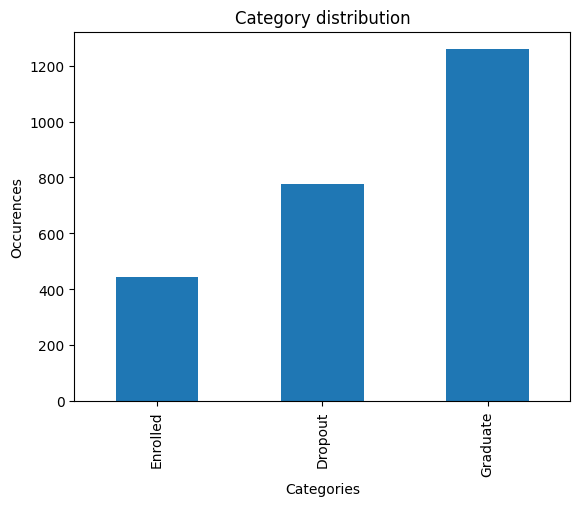

In [4]:
train_set['Category'].value_counts()
category_plot = train_set.Category.value_counts().sort_values().plot(kind = 'bar')
category_plot.set_title("Category distribution")
category_plot.set_xlabel('Categories')
category_plot.set_ylabel('Occurences')

In [6]:
one_hot_encoded_target = pd.get_dummies(train_set, columns = ['Category'])
one_hot_encoded_target.head()

,Id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Category_Dropout,Category_Enrolled,Category_Graduate
0,3222,1,1,1,14,1,1,1,13,28,...,7,6,14.714286,0,11.1,0.6,2.02,0,0,1
1,2388,1,8,4,9,1,1,1,23,14,...,10,2,12.500000,0,11.1,0.6,2.02,1,0,0
2,1865,1,12,1,17,0,1,1,1,1,...,5,5,12.400000,0,15.5,2.8,-4.06,0,0,1
3,652,1,12,1,12,1,12,1,1,5,...,11,7,12.614286,0,12.7,3.7,-1.70,0,0,1
4,4220,1,1,1,14,1,1,1,19,28,...,5,0,0.000000,0,9.4,-0.8,-3.12,1,0,0


In [23]:
train_set['Marital status'].value_counts()

1    2201
0     275
Name: Marital status, dtype: int64

In [3]:
def previous_higher_education(row):
    if (row['Previous qualification'] >= 2 and row['Previous qualification'] <= 6) or row['Previous qualification'] >= 15:
        val = 1
    else:
        val = 0
    return val 

In [7]:
one_hot_encoded_target['previous high education'] = one_hot_encoded_target.apply(previous_higher_education, axis=1)

In [4]:
def mothers_higher_education(row):
    if (row['Mother\'s qualification'] >= 2 and row['Mother\'s qualification'] <= 6) or (row['Mother\'s qualification'] >= 30):
        val = 1
    else:
        val = 0
    return val   

In [27]:
one_hot_encoded_target['Mother has Higher Education'] = one_hot_encoded_target.apply(mothers_higher_education, axis=1)

In [5]:
def fathers_higher_education(row):
    if (row['Father\'s qualification'] >= 2 and row['Father\'s qualification'] <= 6) or (row['Father\'s qualification'] >= 30):
        val = 1
    else:
        val = 0
    return val   

In [29]:
one_hot_encoded_target['Father has Higher Education'] = one_hot_encoded_target.apply(fathers_higher_education, axis=1)

In [8]:
one_hot_encoded_target["Marital status"] = np.where(one_hot_encoded_target["Marital status"] == 1, 1, 0)
one_hot_encoded_target["Nacionality"] = np.where(one_hot_encoded_target["Nacionality"] == 1, 1, 0)

Text(0.5, 1.0, 'Correlation heatmap')

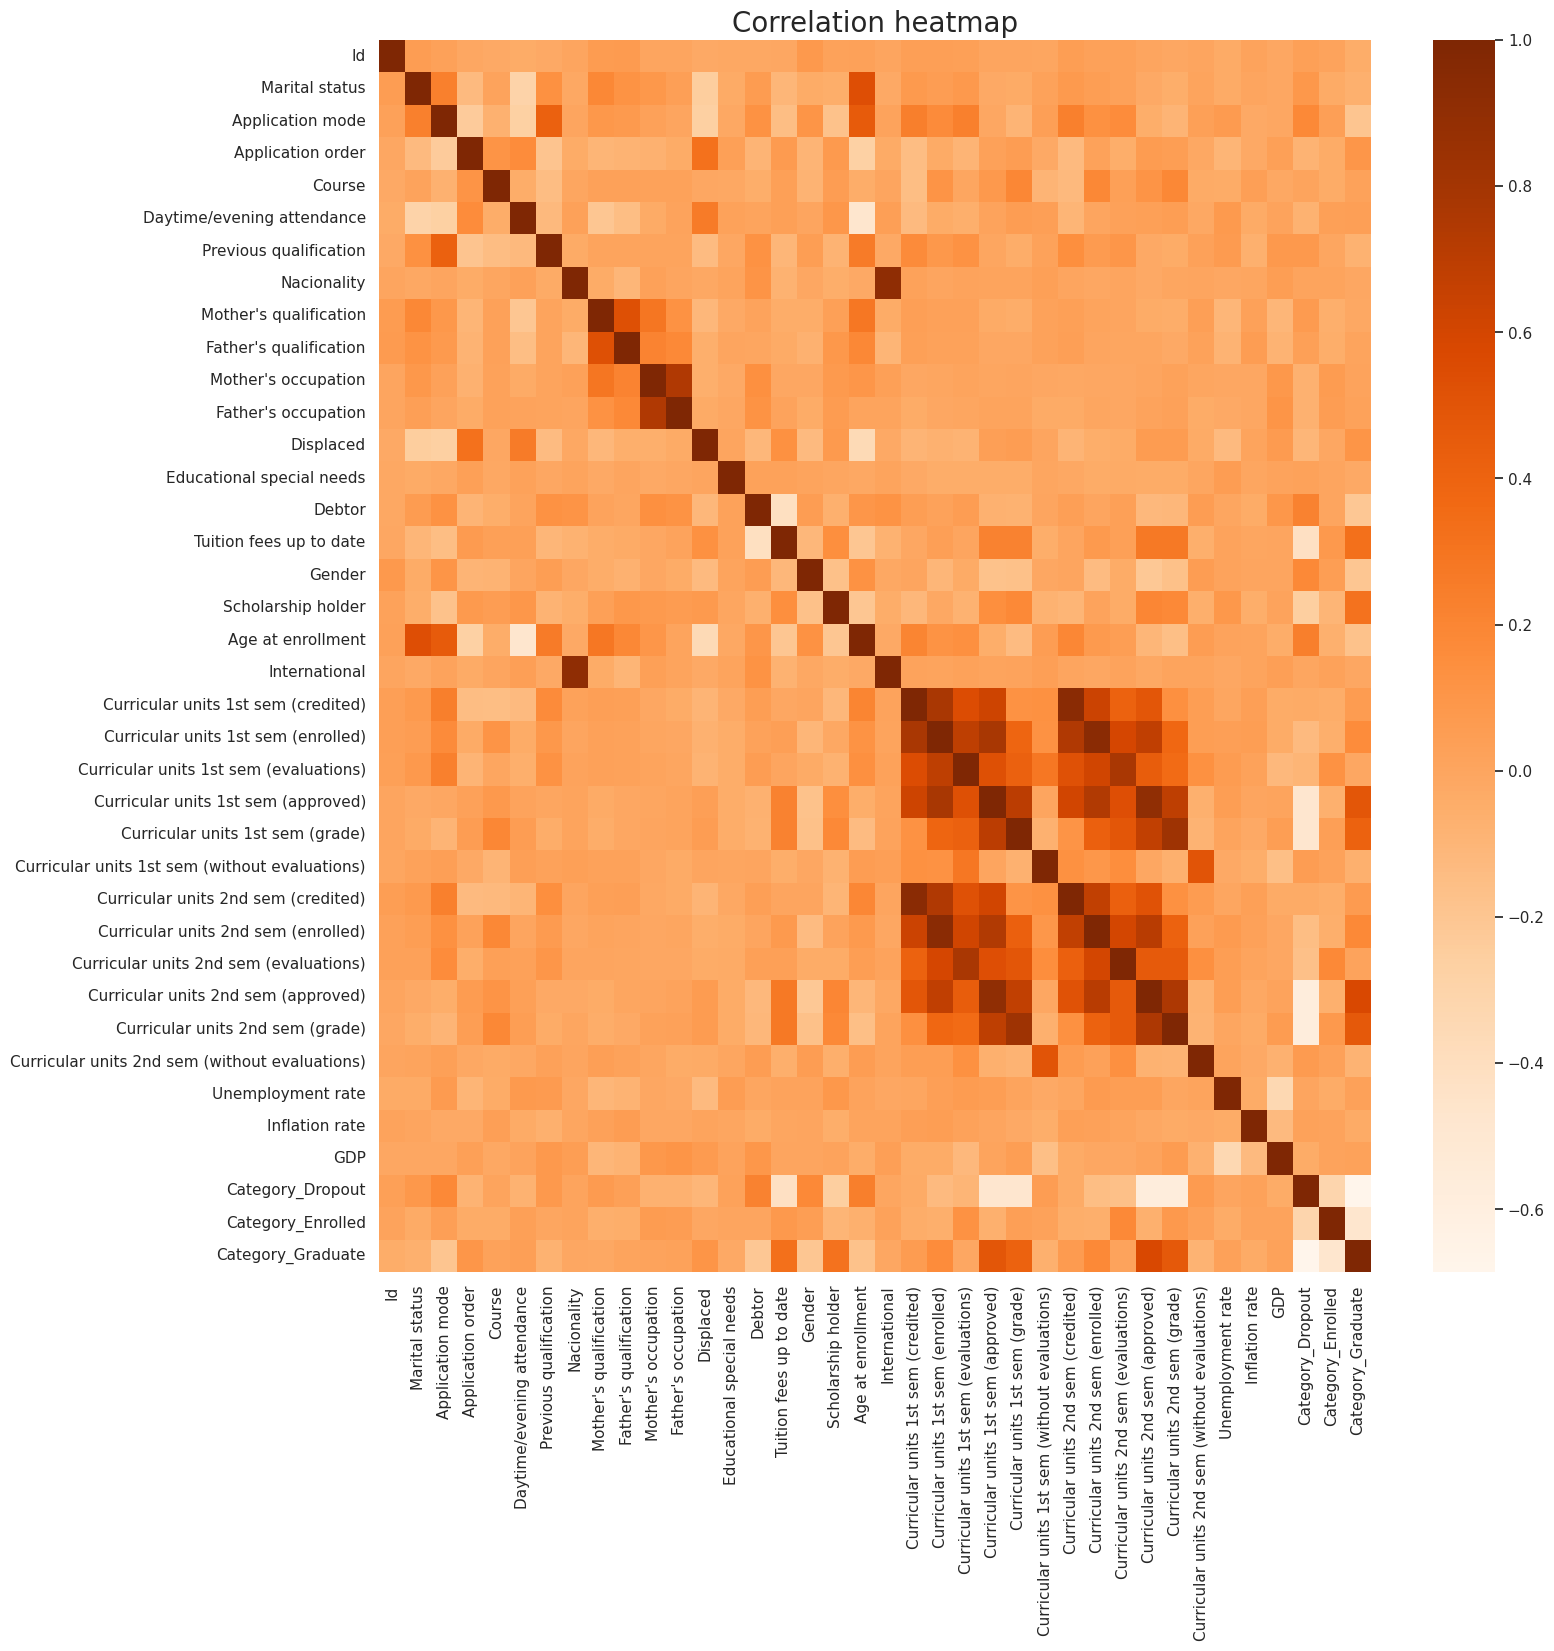

In [8]:
sns.set(rc={'figure.figsize':(16,16)})

heatmap = sns.heatmap(one_hot_encoded_target.corr(), cmap="Oranges")
heatmap.axes.set_title("Correlation heatmap", fontsize=20)

Text(0.5, 1.0, 'Correlation heatmap for each category')

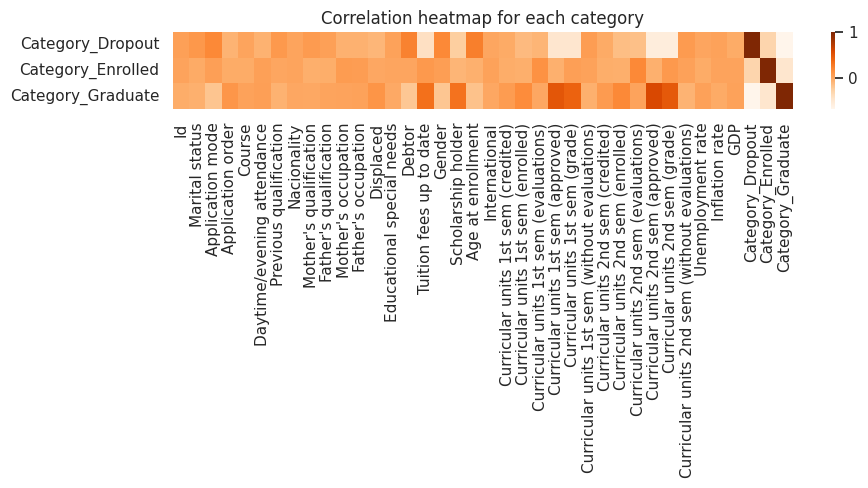

In [28]:
sns.set(rc={'figure.figsize':(10,1)})
corr = one_hot_encoded_target.corr()
categories = corr.iloc[-3:]
heatmap = sns.heatmap(categories, cmap="Oranges")
heatmap.set_title("Correlation heatmap for each category")


Text(0.5, 1.0, 'Correlation heatmap for each category')

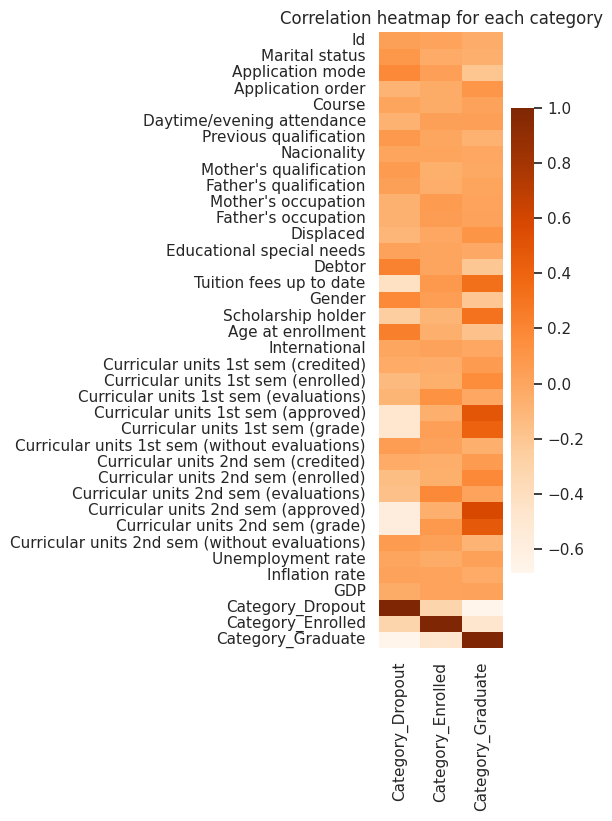

In [32]:
sns.set(rc={'figure.figsize':(2,8)})
corr = one_hot_encoded_target.corr()
categories = corr[['Category_Dropout', 'Category_Enrolled', 'Category_Graduate']]
heatmap = sns.heatmap(categories, cmap="Oranges")
heatmap.set_title("Correlation heatmap for each category")

----

# Feature extraction and engineering

In [10]:
train_set[train_set.duplicated()]

,Id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Category


### Modifying "Marital status" to 1 if "single", else 0

In [4]:
train_set["Marital status"] = np.where(train_set["Marital status"] == 1, 1, 0)
validation_set["Marital status"] = np.where(validation_set["Marital status"] == 1, 1, 0)
test_set["Marital status"] = np.where(test_set["Marital status"] == 1, 1, 0)

In [5]:
clean_train_set = train_set[['Marital status', 'Application order', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'Displaced', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)']]

#clean_train_set['Father has Higher Education'] = train_set.apply(fathers_higher_education, axis=1)
#clean_train_set['Mother has Higher Education'] = train_set.apply(mothers_higher_education, axis=1)
clean_train_set['Previous Higher Education'] = train_set.apply(previous_higher_education, axis=1)


/tmp/ipykernel_4448/1376116251.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_train_set['Previous Higher Education'] = train_set.apply(previous_higher_education, axis=1)


In [6]:
clean_train_set.columns

Index(['Marital status', 'Application order', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'Displaced', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)',
       'Previous Higher Education'],
      dtype='object')

In [13]:
#one_hot_encoded = pd.get_dummies(train_set['Course'], prefix="course")
#clean_train_set = pd.merge(clean_train_set, one_hot_encoded, how='left', left_index=True, right_index=True)
#clean_train_set

In [6]:
clean_validation_set = validation_set[['Marital status', 'Application order', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'Displaced', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)']]

#clean_validation_set['Father has Higher Education'] = validation_set.apply(fathers_higher_education, axis=1)
#clean_validation_set['Mother has Higher Education'] = validation_set.apply(mothers_higher_education, axis=1)
clean_validation_set['Previous Higher Education'] = validation_set.apply(previous_higher_education, axis=1)

/tmp/ipykernel_4448/448873665.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_validation_set['Previous Higher Education'] = validation_set.apply(previous_higher_education, axis=1)


In [ ]:
#one_hot_encoded = pd.get_dummies(validation_set['Course'], prefix="course")
#clean_validation_set = pd.merge(clean_validation_set, one_hot_encoded, how='left', left_index=True, right_index=True)
#clean_validation_set

In [15]:
clean_test_set = test_set[['Marital status', 'Application order', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'Displaced', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)']]
clean_test_set

# clean_validation_set['Father has Higher Education'] = train_set.apply(fathers_higher_education, axis=1)
# clean_validation_set['Mother has Higher Education'] = train_set.apply(mothers_higher_education, axis=1)
clean_test_set['Previous Higher Education'] = test_set.apply(previous_higher_education, axis=1)

/tmp/ipykernel_23694/2213905173.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_test_set['Previous Higher Education'] = test_set.apply(previous_higher_education, axis=1)


----

# Oversampling

In [7]:
# transform the train dataset
oversample = SMOTE()
X, y = oversample.fit_resample(clean_train_set, train_set['Category'])
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{'Dropout': 1258, 'Enrolled': 1258, 'Graduate': 1258}

----

# Model trainig and prediction

### Multinomial Logistic Regression

In [11]:
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1)

#X = clean_train_set
#y = train_set['Category']

# fit the model on the whole dataset
model.fit(X, y)

/home/tania/becode/student-dropout-challenge/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=1)

In [12]:
model.score(X, y)

0.7429782723900371

In [11]:
# predict the class label on the validation set
prediction = model.predict(clean_validation_set)

In [20]:
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{'Dropout': 402, 'Enrolled': 282, 'Graduate': 644}

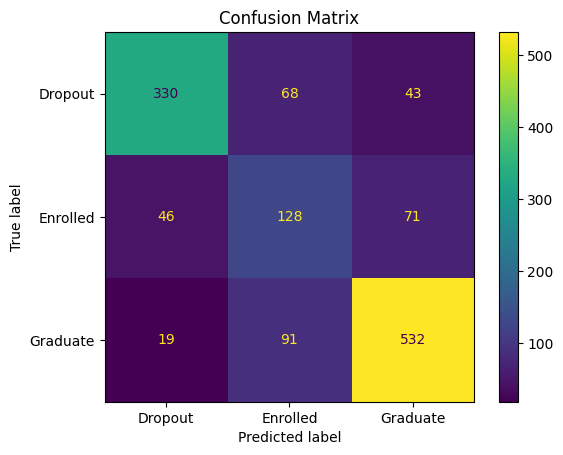

In [12]:
confusion = confusion_matrix(validation_set['Category'], prediction, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=model.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [13]:
print(classification_report(validation_set['Category'], prediction, target_names=['Dropout', 'Enrolled', 'Graduate']))

              precision    recall  f1-score   support

     Dropout       0.84      0.75      0.79       441
    Enrolled       0.45      0.52      0.48       245
    Graduate       0.82      0.83      0.83       642

    accuracy                           0.75      1328
   macro avg       0.70      0.70      0.70      1328
weighted avg       0.76      0.75      0.75      1328



In [21]:
# Generate class probabilities
y_probs = model.predict_proba(clean_validation_set)
auroc = roc_auc_score(validation_set['Category'], y_probs, average="weighted", multi_class="ovr")
print("average AUROC: " + str(auroc))

average AUROC: 0.8806463304672629


### SVM

- linear SVM

In [14]:
# define the linear svm model
model = SVC(kernel='linear', C=1, decision_function_shape='ovo')

In [15]:
# fit the model on the dataset
model.fit(X, y)
model.score(X, y)

0.7413884472708002

In [24]:
# predict the class label on the validation set
prediction = model.predict(clean_validation_set)
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{'Dropout': 384, 'Enrolled': 304, 'Graduate': 640}

In [25]:
confusion = confusion_matrix(validation_set['Category'], prediction)
confusion

array([[322,  78,  41],
       [ 43, 132,  70],
       [ 19,  94, 529]])

In [26]:
print(classification_report(validation_set['Category'], prediction, target_names=['Dropout', 'Enrolled', 'Graduate']))

              precision    recall  f1-score   support

     Dropout       0.84      0.73      0.78       441
    Enrolled       0.43      0.54      0.48       245
    Graduate       0.83      0.82      0.83       642

    accuracy                           0.74      1328
   macro avg       0.70      0.70      0.70      1328
weighted avg       0.76      0.74      0.75      1328



- Radial Basis Function (RBF) SVM

In [14]:
# define the RBF svm model
model = SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo')

In [15]:
# fit the model on the dataset
model.fit(X, y)
model.score(X, y)

0.990990990990991

In [16]:
# predict the class label on the validation set
prediction = model.predict(clean_validation_set)
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{'Dropout': 189, 'Enrolled': 50, 'Graduate': 1089}

In [17]:
print(classification_report(validation_set['Category'], prediction, target_names=['Dropout', 'Enrolled', 'Graduate']))

              precision    recall  f1-score   support

     Dropout       0.76      0.32      0.45       441
    Enrolled       0.32      0.07      0.11       245
    Graduate       0.55      0.93      0.69       642

    accuracy                           0.57      1328
   macro avg       0.54      0.44      0.42      1328
weighted avg       0.58      0.57      0.51      1328



### Random Forest

In [9]:
# define the Random Forest model
model = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 3)

In [10]:
# fit the model on the dataset
model.fit(X, y)
model.score(X, y)

0.990990990990991

In [11]:
# predict the class label on the validation set
prediction = model.predict(clean_validation_set)
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{'Dropout': 401, 'Enrolled': 261, 'Graduate': 666}

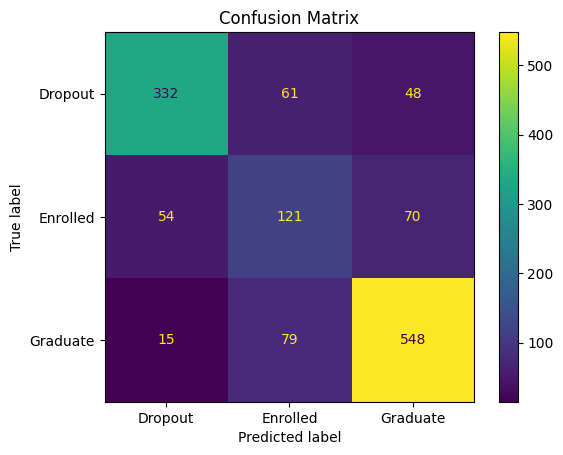

In [14]:
confusion = confusion_matrix(validation_set['Category'], prediction, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=model.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [13]:
print(classification_report(validation_set['Category'], prediction, target_names=['Dropout', 'Enrolled', 'Graduate']))

              precision    recall  f1-score   support

     Dropout       0.82      0.75      0.78       441
    Enrolled       0.45      0.48      0.47       245
    Graduate       0.82      0.85      0.83       642

    accuracy                           0.75      1328
   macro avg       0.70      0.69      0.70      1328
weighted avg       0.75      0.75      0.75      1328



In [21]:
mat_coef = matthews_corrcoef(validation_set['Category'], prediction)
print("Matthew’s correlation coefficient: " + str(mat_coef))

Matthew’s correlation coefficient: 0.6041739368493156


In [26]:
# Generate class probabilities
y_probs = model.predict_proba(clean_validation_set)
auroc = roc_auc_score(validation_set['Category'], y_probs, average="weighted", multi_class="ovr")
print("average AUROC: " + str(auroc))
y_probs

average AUROC: 0.8819650149117639


array([[0.57, 0.34, 0.09],
       [0.03, 0.31, 0.66],
       [0.06, 0.17, 0.77],
       ...,
       [0.  , 0.21, 0.79],
       [0.27, 0.47, 0.26],
       [1.  , 0.  , 0.  ]])

In [41]:
classes = model.classes_
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in classes:
    print(prediction[:, i])
    #fpr[i], tpr[i], _ = roc_curve(validation_set['Category'][:, i], prediction[:, i])
    #roc_auc[i] = auc(fpr[i], tpr[i])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### XGBoost

In [15]:
def target_coding(row):
    if row['Category'] == "Dropout":
        val = 0
    elif row['Category'] == "Enrolled":
        val = 1
    else:
        val = 2
    return val 

In [16]:
y_train = pd.DataFrame()

In [20]:
y_copy = pd.DataFrame(y)
y_copy

,Category
0,Graduate
1,Dropout
2,Graduate
3,Graduate
4,Dropout
...,...
3769,Enrolled
3770,Enrolled
3771,Enrolled
3772,Enrolled


In [21]:
y_train['Category'] = y_copy.apply(target_coding, axis=1)
y_train

,Category
0,2
1,0
2,2
3,2
4,0
...,...
3769,1
3770,1
3771,1
3772,1


In [22]:
# define the Random Forest model
model = XGBClassifier()

In [24]:
# fit the model on the dataset
model.fit(X, y_train)
model.score(X, y_train)

0.9859565447800742

In [25]:
# predict the class label on the validation set
prediction = model.predict(clean_validation_set)
unique, counts = np.unique(prediction, return_counts=True)
dict(zip(unique, counts))

{0: 407, 1: 256, 2: 665}

In [29]:
y_val = pd.DataFrame()

,Id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Category
0,1255,0,12,1,8,1,1,1,3,1,...,0,6,16,1,10.000000,0,11.1,0.6,2.02,Dropout
1,3458,1,8,1,10,1,1,1,4,3,...,0,6,8,6,12.142857,0,16.2,0.3,-0.92,Graduate
2,3390,1,8,1,16,1,1,1,23,28,...,0,7,7,7,12.285714,0,16.2,0.3,-0.92,Graduate
3,1497,1,8,2,14,1,1,1,1,1,...,0,6,8,5,13.000000,0,15.5,2.8,-4.06,Graduate
4,1536,1,12,1,12,1,1,1,22,14,...,0,7,14,0,0.000000,0,11.1,0.6,2.02,Dropout
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,979,1,9,1,4,1,1,1,1,28,...,3,9,14,8,12.250000,0,15.5,2.8,-4.06,Graduate
1324,283,1,1,1,5,1,1,1,13,27,...,0,6,6,6,12.833333,0,16.2,0.3,-0.92,Graduate
1325,1298,1,1,1,17,0,1,1,2,27,...,0,5,7,5,11.800000,0,7.6,2.6,0.32,Graduate
1326,898,1,1,1,11,1,1,1,23,14,...,0,6,10,4,11.000000,0,7.6,2.6,0.32,Enrolled


In [33]:
y_val['Category'] = validation_set.apply(target_coding, axis=1)
y_val

,Category
0,0
1,2
2,2
3,2
4,0
...,...
1323,2
1324,2
1325,2
1326,1


In [35]:
print(classification_report(y_val['Category'], prediction, target_names=["0", "1", "2"]))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       441
           1       0.42      0.44      0.43       245
           2       0.80      0.83      0.82       642

    accuracy                           0.72      1328
   macro avg       0.67      0.66      0.66      1328
weighted avg       0.72      0.72      0.72      1328



----

# Saving the results to csv

In [16]:
# predict final classification on the test set
prediction = model.predict(clean_test_set)

In [17]:
df = pd.DataFrame({'Category': prediction})
df.head()

,Category
0,Dropout
1,Graduate
2,Graduate
3,Dropout
4,Graduate


In [18]:
test_set_id = test_set[['Id']]
test_set_id.head()

,Id
0,3557
1,1980
2,1112
3,2914
4,2745


In [19]:
final_df = pd.merge(test_set_id, df, how='left', left_index=True, right_index=True)
final_df

,Id,Category
0,3557,Dropout
1,1980,Graduate
2,1112,Graduate
3,2914,Dropout
4,2745,Graduate
...,...,...
615,335,Graduate
616,1639,Graduate
617,1381,Dropout
618,2455,Graduate


In [20]:
final_df.to_csv('prediction.csv', index=False)

---

# Results bechmark
- multinomial logistic regession, features 'Age' and 'Scholarship'. Score : 0.5642
- multinomial logistic regession, features 'Age' and 'Scholarship'. SMOTE. Score : 0.4888
- multinomial logistic regession, features 'Age', 'Scholarship', 'Tuition fees' . SMOTE. 0.5188
